In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import time
import datetime as dt
from datetime import datetime
import numpy as np
import pandas as pd

/anaconda3/envs/PythonData/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
#SQLAlchemy
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
ab = automap_base()
ab.prepare(engine, reflect=True)
Measurement = ab.classes.measurement
Station = ab.classes.station
ab.classes.keys()

['measurement', 'station']

In [5]:
session = Session(engine)

In [6]:
ins = inspect(engine)
ins.get_table_names()

['measurement', 'station']

In [7]:
#list column names and types measurements
columns = ins.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
#list of column names and types stations
columns = ins.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [25]:
dd = dt.date(2016 ,8, 1)

m = int(dt.date.today().strftime("%m"))
d = int(dt.date.today().strftime("%d"))
y = int(dt.date.today().strftime("%y"))
year_ago_date = dt.date(y, m, d) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.prcp).filter(Measurement.date > d).all()
rain_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > d).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain_data)

# Sort the dataframe by date
rain_df = rain_df.sort_values(by ="date") 
rain_df=rain_df.dropna(how='any')
# Use Pandas Plotting with Matplotlib to plot the data

# Rotate the xticks for the dates
fig, ax = plt.subplots()
fig = plt.scatter(rain_df.date,rain_df.prcp)
plt.xticks(rotation=45)
plt.xlabel("date")
plt.ylabel("precipitation")
leg = ax.legend()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

KeyError: 'date'

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
rain_df.describe()

ValueError: Cannot describe a DataFrame without columns

In [12]:
# How many stations are available in this dataset?
stations = session.query(Measurement.station).all()
stations = pd.DataFrame(stations)
num_stations = stations.nunique()
num_stations = num_stations[0]
print(f'There are {num_stations} stations in the dataset')

There are 9 stations in the dataset


In [13]:
from sqlalchemy import distinct
number_stations = session.query(func.count(distinct(Measurement.station))).all()
number_stations[0]

(9)

In [14]:
# List the stations and the counts in descending order.
order = stations.station.value_counts()
order

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: station, dtype: int64

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_id = "USC00519281"
max_station = session.query(func.max(Measurement.tobs)).filter(Measurement.station == station_id).all()
#session.query(func.max(Table.column))
print("Maximum temp - " + str(max_station[0][0]))
min_station = session.query(func.min(Measurement.tobs)).filter(Measurement.station == station_id).all()
print("Minimum temp - "+ str(min_station[0][0]))
avg_station = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == station_id).all()
print("Average temp - " + str(avg_station[0][0]))


Maximum temp - 85.0
Minimum temp - 54.0
Average temp - 71.66378066378067


In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).all()

[('USC00511918', 1979),
 ('USC00513117', 2709),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00517948', 1372),
 ('USC00518838', 511),
 ('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00519523', 2669)]

In [17]:
temp_station = "USC00519281"
hT_df = session.query(Measurement.date,Measurement.tobs).filter(Measurement.date > dt).all()
hT_df = pd.DataFrame(hT_df)
hT_df = hT_df.dropna(how="any")
hT_df = hT_df.sort_values(by="date")
bins = 12
fig, ax = plt.subplots()
n, bins, patches = ax.hist(hT_df.tobs, bins)
plt.xlabel("temperature")
plt.ylabel("frequency")
leg = ax.legend();

InterfaceError: (sqlite3.InterfaceError) Error binding parameter 0 - probably unsupported type. [SQL: 'SELECT measurement.date AS measurement_date, measurement.tobs AS measurement_tobs \nFROM measurement \nWHERE measurement.date > ?'] [parameters: (<module 'datetime' from '/anaconda3/envs/PythonData/lib/python3.6/datetime.py'>,)] (Background on this error at: http://sqlalche.me/e/rvf5)

In [18]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
print(calc_temps('2015-06-18','2015-06-25'))

[(70.0, 75.61666666666666, 80.0)]


<IPython.core.display.Javascript object>


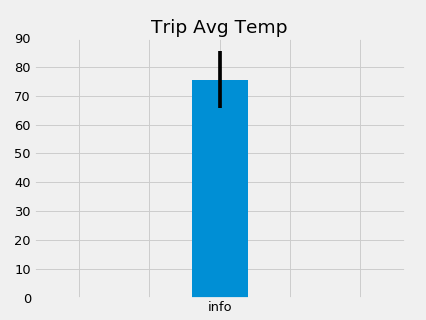

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
t_mean = 75.61666666666666
t_min = 70.0
t_max = 80.0
fig, ax1 = plt.subplots()
height = [0, 0, t_mean, 0, 0]

# Choose the names of the bars
bars = ('', '', 'info', '', '')
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height,yerr=[0,0,t_max-t_min,0,0])
 
# Create names on the x-axis
plt.xticks(y_pos, bars, color='black')
plt.yticks(color='black')
plt.title("Trip Avg Temp")
 
# Show graphic
plt.show()


In [22]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
query_date1 = dt.date(2015, 6, 18)
query_date2 = dt.date(2015, 6, 25)
trip_data = session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation).filter(Measurement.date > query_date1)\
    .filter(Measurement.date < query_date2).group_by(Station.station).all()
trip_data = pd.DataFrame(trip_data)
trip_data

,station,name,latitude,longitude,elevation
0,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
8,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5


In [23]:
rain_info = session.query(Station.station,func.sum(Measurement.prcp).label("Total station prcp")).filter(Measurement.date > query_date1).filter(Measurement.date < query_date2).group_by(Measurement.station)\
    .order_by(func.sum(Measurement.prcp).desc()).all()
rain_info = pd.DataFrame(rain_info)
rain_info

,station,Total station prcp
0,USC00516128,19.80
1,USC00516128,5.58
2,USC00516128,2.25
3,USC00516128,1.35
4,USC00516128,1.17
5,USC00516128,0.99
6,USC00516128,0.45
7,USC00516128,0.00
